<div style="display: flex; align-items: center; justify-content: center; flex-wrap: wrap;">
    <div style="flex: 1; max-width: 400px; display: flex; justify-content: center;">
        <img src="https://i.ibb.co/JBPWVYR/Logo-Nova-IMS-Black.png" style="max-width: 50%; height: auto; margin-top: 50px; margin-bottom: 50px;margin-left: 6rem;">
    </div>
    <div style="flex: 2; text-align: center; margin-top: 20px;margin-left: 8rem;">
        <div style="font-size: 28px; font-weight: bold; line-height: 1.2;">
            <span style="color: #22c1c3;">DL Project |</span> <span style="color: #08529C;">Predicting Rare Species from Images using Deep Learning</span>
        </div>
        <div style="font-size: 17px; font-weight: bold; margin-top: 10px;">
            Spring Semester | 2024 - 2025
        </div>
        <div style="font-size: 17px; font-weight: bold;">
            Master in Data Science and Advanced Analytics
        </div>
        <div style="margin-top: 20px;">
            <div>André Silvestre, 20240502</div>
            <div>Diogo Duarte, 20240525</div>
            <div>Filipa Pereira, 20240509</div>
            <div>Maria Cruz, 20230760</div>
            <div>Umeima Mahomed, 20240543</div>
        </div>
        <div style="margin-top: 20px; font-weight: bold;">
            Group 37
        </div>
    </div>
</div>

<div style="background: linear-gradient(to right, #22c1c3, #27b1dd, #2d9cfd, #090979); 
            padding: 1px; color: white; border-radius: 500px; text-align: center;">
</div>

## **📚 Libraries Import**

In [1]:
# System imports
import os
import sys
import time
import datetime
from tqdm import tqdm
from typing_extensions import Self, Any      # For Python 3.10
# from typing import Self, Any               # For Python >3.11

from pathlib import Path

# Data manipulation imports
import numpy as np
import pandas as pd  
import warnings
warnings.filterwarnings("ignore")

# Data visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning imports
import tensorflow as tf
from keras.ops import add
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Model, Sequential, Input
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

# Image processing imports (Data Augmentation)
from tensorflow.keras.layers import (
    Resizing, Rescaling, CenterCrop, AutoContrast, Equalization, MixUp, 
    RandAugment, RandomBrightness, RandomColorDegeneration, RandomColorJitter, RandomContrast, 
    RandomCrop, RandomFlip, RandomGrayscale, RandomHue, RandomRotation, RandomSaturation, RandomSharpness, 
    RandomShear, RandomTranslation, RandomZoom
)
# Evaluation imports
from sklearn.metrics import confusion_matrix, classification_report
from keras.metrics import CategoricalAccuracy, AUC, F1Score, Precision, Recall

# Other imports
from itertools import product

# Image processing imports
from matplotlib.image import imread
from PIL import Image

# Set the style of the visualization
pd.set_option('future.no_silent_downcasting', True)   # use int instead of float in DataFrame
pd.set_option("display.max_columns", None)            # display all columns

# Disable warnings (FutureWarning)
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# For better resolution plots
%config InlineBackend.figure_format = 'retina'
# Setting seaborn style
sns.set_theme(style="white")

# Set random seed for reproducibility
np.random.seed(2025)

2025-04-01 14:57:36.248644: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743515856.397160    8508 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743515856.452271    8508 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-01 14:57:36.856596: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("TensorFlow Version:", tf.__version__)
print("Is TensorFlow built with CUDA?", tf.test.is_built_with_cuda())
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("GPU Device Name:", tf.test.gpu_device_name())                                # (if error in Google Colab: Make sure your Hardware accelerator is set to GPU. 
                                                                                    # Runtime > Change runtime type > Hardware Accelerator)

TensorFlow Version: 2.18.0
Is TensorFlow built with CUDA? True
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU Device Name: /device:GPU:0


I0000 00:00:1743515861.188422    8508 gpu_device.cc:2022] Created device /device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [3]:
# Extra: https://www.tensorflow.org/api_docs/python/tf/config/experimental/set_memory_growth
# If you’re using a GPU, TensorFlow might pre-allocate GPU memory, leaving less for CPU operations. 
# Enabling memory growth lets the GPU allocate only what’s needed.
if tf.test.is_built_with_cuda():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        tf.config.experimental.set_memory_growth(gpus[0], True)

In [4]:
# Auxiliary function to display multiple dataframes side by side
# Source: https://python.plainenglish.io/displaying-multiple-dataframes-side-by-side-in-jupyter-lab-notebook-9a4649a4940
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args, super_title, titles=cycle([''])):
    """
    :param args: Variable number of DataFrame objects to be displayed side by side.
    :param super_title: The main title to be displayed at the top of the combined view.
    :param titles: An iterable containing titles for each DataFrame to be displayed. Defaults to an infinite cycle of empty strings.
    
    :return: None. The function generates and displays HTML content side by side for given DataFrames.
    """
    html_str = ''
    html_str += f'<h1 style="text-align: left; margin-bottom: -15px;">{super_title}</h1><br>'
    html_str += '<div style="display: flex;">'
    for df, title in zip(args, chain(titles, cycle(['</br>']))):
        html_str += f'<div style="margin-right: 20px;"><h3 style="text-align: center;color:#555555;">{title}</h3>'
        html_str += df.to_html().replace('table', 'table style="display:inline; margin-right: 20px;"')
        html_str += '</div>'
    html_str += '</div>'
    display_html(html_str, raw=True)

## **🧮 Import Databases**

In [5]:
# # Run in Google Collab to download the dataset already splitted
# # Source: https://stackoverflow.com/questions/25010369/wget-curl-large-file-from-google-drivez
# # Download the file from Google Drive using wget
# !wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate \
#   "https://drive.usercontent.google.com/download?id=1CxoEypMtEp_Uzh9MiCJKWmQ9OBs7iNdY&export=download" -O- | \
#   sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p' > /tmp/confirm.txt

# # Read the confirmation token from the temporary file
# with open('/tmp/confirm.txt', 'r') as f:
#     confirm_token = f.read().strip()

# # Download the file using the confirmation token and cookies
# !wget --load-cookies /tmp/cookies.txt \
#   "https://drive.usercontent.google.com/download?id=1CxoEypMtEp_Uzh9MiCJKWmQ9OBs7iNdY&export=download&confirm={confirm_token}" \
#   -O /content/RareSpecies_Split.zip

# # Clean up temporary files
# !rm /tmp/cookies.txt /tmp/confirm.txt

# # List files in the /content directory to verify the download
# !ls -lh /content/

# # Unzip the downloaded file
# !unzip /content/RareSpecies_Split.zip -d /content/

# # List the unzipped files to verify
# !ls -lh /content/

In [6]:
# Define the path to the data
train_dir = Path("data/train")
val_dir = Path("data/val")
test_dir = Path("data/test")

# For Google Collab
# train_dir = Path("/content/RareSpecies_Split/train")
# val_dir = Path("/content/RareSpecies_Split/val")
# test_dir = Path("/content/RareSpecies_Split/test")

In [32]:
# Image Generators
n_classes = 202                                     # Number of classes (we already know this based on previous notebook)
image_size = (224, 224)                             # Size of the images
img_width, img_height = 224, 224               
batch_size = 16                                     # Batch size
input_shape = (img_width, img_height, 3)            # Input shape of the model
value_range = (0.0, 1.0)                            # Range of pixel values

# Data generators with built-in rescaling (no augmentation yet)
# Source: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
#         https://stackoverflow.com/questions/59228816/what-do-the-tensorflow-datasets-functions-cache-and-prefetch-do

# Training data generator
train_datagen = image_dataset_from_directory(
    train_dir,                                      # Path to the directory
    labels='inferred',                              # Type of labels to generate (inferred = from the directory structure)
    label_mode='categorical',                       # Type of labels to generate (categorical = 'float32' tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.)
    color_mode='rgb',                               # Color mode to read images
    batch_size=batch_size,                          # Size of the batches of data
    image_size=image_size,                          # Size of the images to read (224x224)
    shuffle=True,                                   # Whether to shuffle the data
    seed=2025,                                      # Random seed for shuffling and transformations
    interpolation='bilinear',                       # Interpolation method to resample the image
)

# Validation data generator
val_datagen = image_dataset_from_directory(
    val_dir, label_mode='categorical', image_size=image_size, batch_size=batch_size, 
    seed=2025, shuffle=True, interpolation='bilinear'
)

# Test data generator
test_datagen = image_dataset_from_directory(
    test_dir, label_mode='categorical', image_size=image_size, batch_size=batch_size, 
    seed=2025, shuffle=True, interpolation='bilinear'
)

print(f"\nLoaded: Train ({train_datagen.cardinality().numpy() * batch_size}), "
        f"Val ({val_datagen.cardinality().numpy() * batch_size}), "
        f"Test ({test_datagen.cardinality().numpy() * batch_size})")

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
Found 1798 files belonging to 202 classes.

Loaded: Train (8400), Val (1808), Test (1808)


In [33]:
# Check the shape of the data (batch_size, img_width, img_height, 3)
for x, y in train_datagen.take(1):
    print("Train batch shape:", x.shape, y.shape)
for x, y in val_datagen.take(1):
    print("Val batch shape:", x.shape, y.shape)
for x, y in test_datagen.take(1):
    print("Test batch shape:", x.shape, y.shape)

Train batch shape: (16, 224, 224, 3) (16, 202)
Val batch shape: (16, 224, 224, 3) (16, 202)
Test batch shape: (16, 224, 224, 3) (16, 202)


# <a class='anchor' id='3'></a>
<br>
<style>
@import url('https://fonts.cdnfonts.com/css/avenir-next-lt-pro?styles=29974');
</style>

<div style="background: linear-gradient(to right, #22c1c3, #27b1dd, #2d9cfd, #090979); 
            padding: 10px; color: white; border-radius: 300px; text-align: center;">
    <center><h1 style="margin-left: 140px;margin-top: 10px; margin-bottom: 4px; color: white;
                       font-size: 32px; font-family: 'Avenir Next LT Pro', sans-serif;">
        <b>3 | Modeling - Baseline Model</b></h1></center>
</div>

<br><br>

In [9]:
# Sample one image filepath from the training set
list(train_datagen.file_paths)[0]

'data/train/chordata_anatidae/20944394_1065125_eol-full-size-copy.jpg'


Preprocessing Experiment (Image 1):


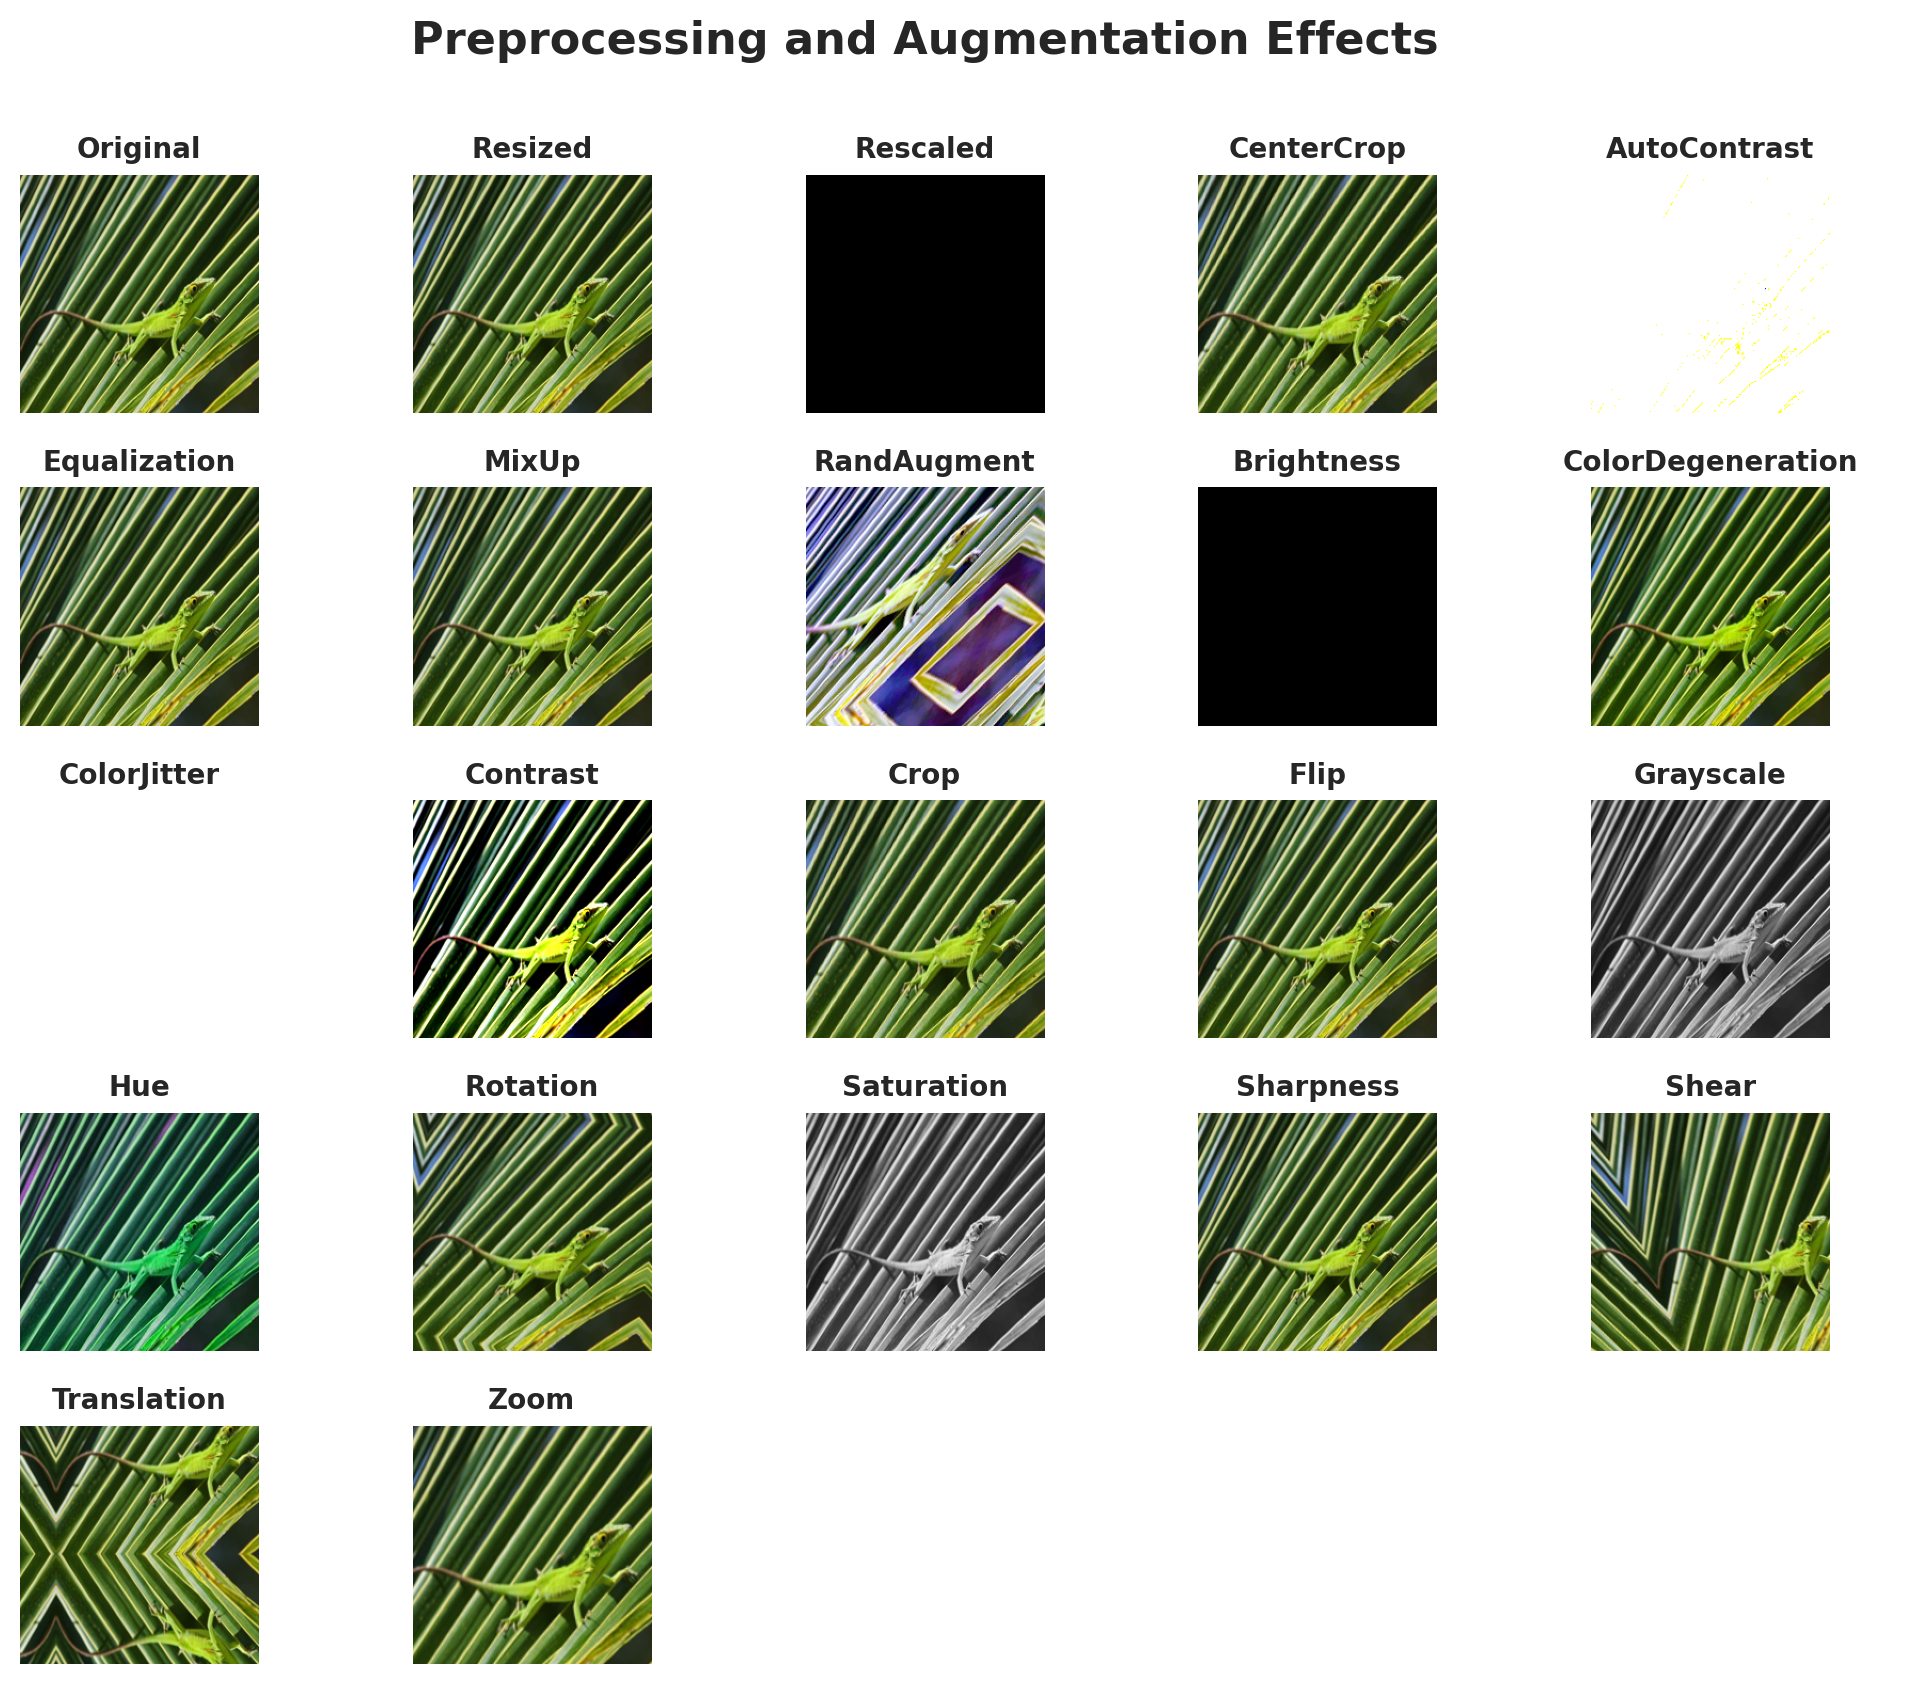


Preprocessing Experiment (Image 2):


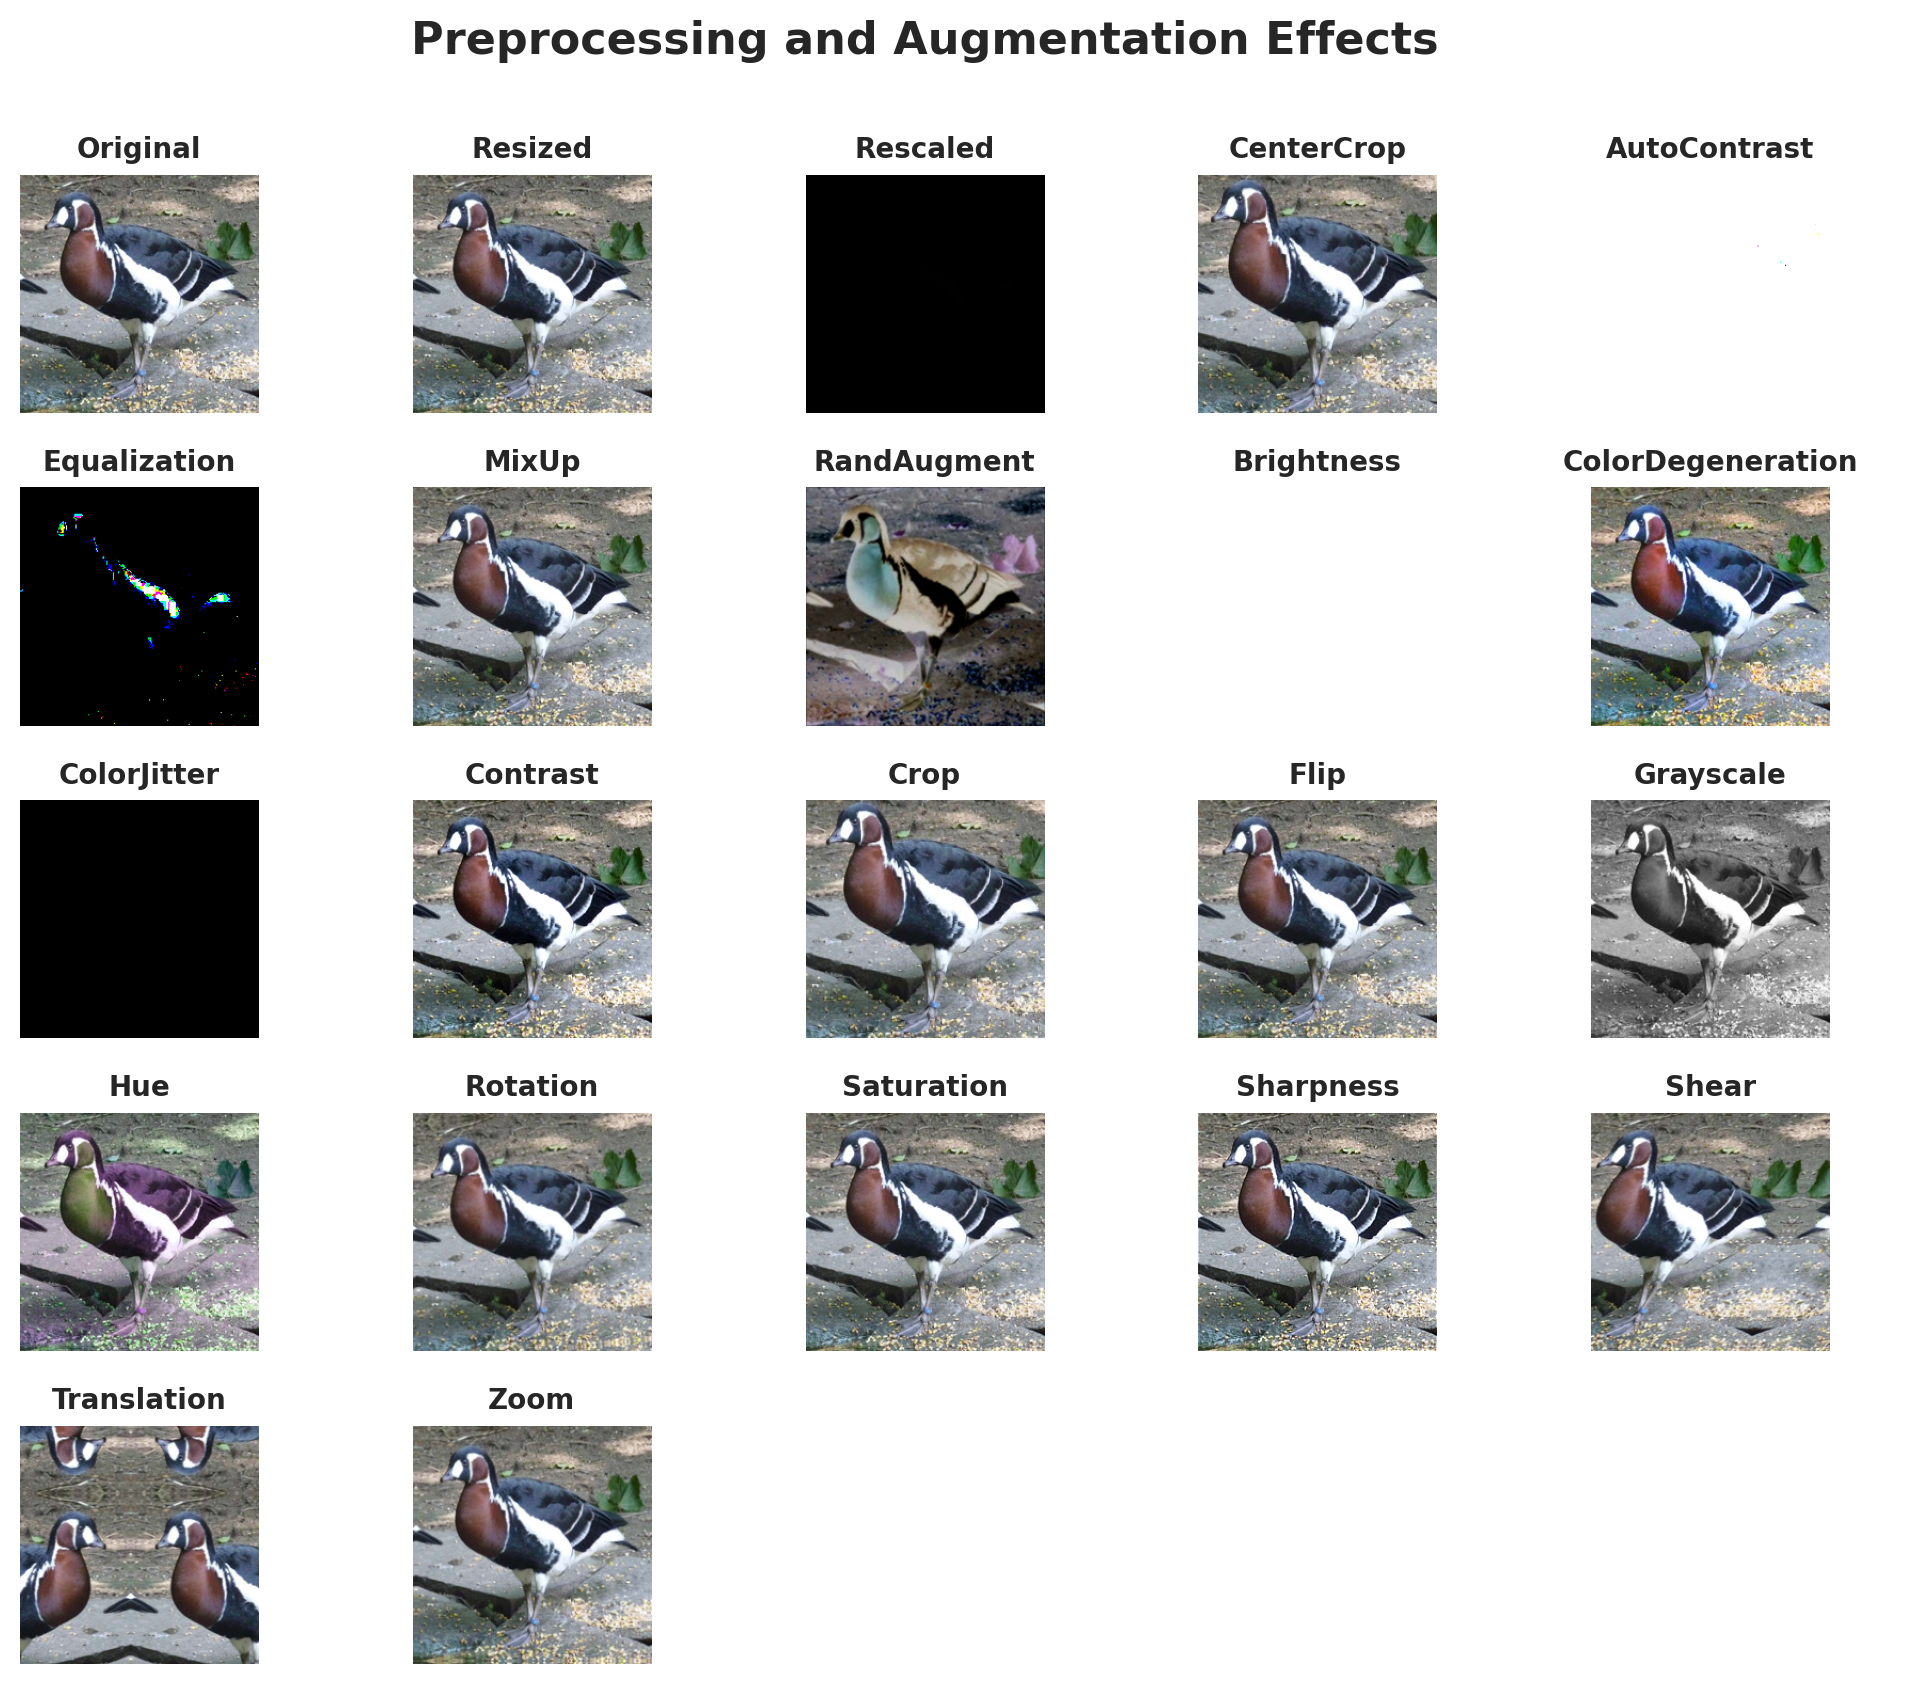

In [10]:
def preprocess_experiment(image_path='data/train/chordata_dactyloidae/29482917_453292_eol-full-size-copy.jpg'):
    """Tests all Keras preprocessing and augmentation layers on a sample image with max effect (factor=1).
    
    Args:
        image_path (str): Path to the sample image.
    
    Returns:
        None: Displays multiple 2xN grids of transformed images.
    
    Notes:
        - Loads image, resizes to 224x224, rescales to [0, 1].
        - Applies all available Keras image preprocessing/augmentation layers.
        - Uses training=True for random layers to ensure application.
        - Splits into multiple 2-row grids for readability.
    """
    # Load and preprocess the image
    try:
        original_img = Image.open(image_path).convert('RGB')  # Ensure RGB format
        img = original_img.resize((224, 224))  # Resize to 224x224
        img_array = np.array(img).astype("float32") / 255.0  # Rescale to [0, 1]
        img_array = tf.expand_dims(img_array, 0)  # Add batch dimension
    except Exception as e:
        print(f"Error loading image: {e}")
        return

    # Define all preprocessing and augmentation layers with max effect
    transformations = [
        ("Original", lambda x: x[0]),                                           # Unchanged image
        ("Resized", Resizing(224, 224)),                                        # Resizes to specified dimensions (redundant here but shown)
        ("Rescaled", Rescaling(1./255)),                                        # Scales pixels to [0, 1] (redundant here)
        ("CenterCrop", CenterCrop(200, 200)),                                   # Crops center to 200x200
        ("AutoContrast", AutoContrast()),                                       # Maximizes contrast across the image
        ("Equalization", Equalization()),                                       # Equalizes histogram for contrast enhancement
        ("MixUp", MixUp(alpha=1.0)),                                            # Blends images (simplified for single image)
        ("RandAugment", RandAugment(value_range=(0, 1))),                       # Randomly applies augmentations at max magnitude
        ("Brightness", RandomBrightness(1.0)),                                  # Adjusts brightness by max factor
        ("ColorDegeneration", RandomColorDegeneration(factor=1.0)),             # Degenerates color to grayscale-like
        ("ColorJitter", RandomColorJitter(brightness_factor=1.0, 
                                          contrast_factor=1.0, 
                                          saturation_factor=1.0)),              # Max jitters brightness, contrast, saturation
        ("Contrast", RandomContrast(1.0)),                                      # Max contrast adjustment
        ("Crop", RandomCrop(200, 200)),                                         # Randomly crops to 200x200
        ("Flip", RandomFlip("horizontal_and_vertical")),                        # Flips both horizontally and vertically
        ("Grayscale", RandomGrayscale(factor=1.0)),                             # Converts to grayscale with 100% probability
        ("Hue", RandomHue(factor=0.5)),                                         # Shifts hue by max factor (0.5 is max valid range)
        ("Rotation", RandomRotation(1.0)),                                      # Rotates by up to 360 degrees (factor=1)
        ("Saturation", RandomSaturation(1.0)),                                  # Adjusts saturation by max factor
        ("Sharpness", RandomSharpness(1.0)),                                    # Enhances sharpness by max factor
        ("Shear", RandomShear(0.5)),                                            # Shears by max factor
        ("Translation", RandomTranslation(0.5, 0.5)),                           # Shifts by max horizontal/vertical factors
        ("Zoom", RandomZoom(0.5)),                                              # Zooms by max factor
    ]

    # Apply transformations and store results
    transformed_imgs = []
    for name, layer in transformations:
        try:
            if name == "Original":
                result = layer(img_array)
            else:
                result = layer(img_array, training=True)  # Force application
            transformed_imgs.append((name, tf.squeeze(result).numpy()))
        except Exception as e:
            print(f"Error applying {name}: {e}")
            transformed_imgs.append((name, img_array[0]))  # Fallback to original

    # Plot in multiple 4-row grids
    n_transforms = len(transformed_imgs)
    n_cols = (n_transforms + 1) // 4                 # Number of columns for 2 rows
    n_rows = (n_transforms + n_cols - 1) // n_cols   # Number of 2xN grids needed

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, 8))    
    for i, (title, img_data) in enumerate(transformed_imgs):
        row, col = divmod(i, n_cols)
        ax[row, col].imshow(np.clip(img_data, 0, 1))  # Ensure valid pixel range
        ax[row, col].set_title(title, fontsize=10, fontweight='bold')
        ax[row, col].axis('off')
    
    # Hide unused subplots
    for i in range(n_transforms, n_rows * n_cols):
        row, col = divmod(i, n_cols)
        ax[row, col].axis('off')
        
    # Adjust layout and display
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.suptitle(f"Preprocessing and Augmentation Effects", fontsize=16, fontweight='bold', y=1.05)
    plt.show()

# Run the experiment with two example images
print("\nPreprocessing Experiment (Image 1):")
preprocess_experiment()
print("\nPreprocessing Experiment (Image 2):")
preprocess_experiment(image_path='data/train/chordata_anatidae/14020527_45513542_eol-full-size-copy.jpg')

# **💡 Modeling**

In [41]:
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2

# Baseline Model
class RareSpeciesCNN(Model):
    """Custom CNN for rare species classification.
    
    Architecture: Simple CNN with two conv blocks, max pooling, and a dense layer.
    Why: Small model to establish baseline, avoiding overfitting on 202 classes.
    Alternatives: Deeper CNNs (e.g., ResNet) or transfer learning (e.g., EfficientNet).
    """
    def __init__(self: Self) -> None:
        """Initializes the model."""
        
        # Call the parent class constructor
        super().__init__()
        
        # Rescaling layer
        self.rescale_layer = Rescaling(scale= 1 / 255.0, name="Rescale_Layer")    # Rescales pixel values to [0, 1]
        
        # Augmentation layer
        # self.augmentation = RandAugment(value_range=(0, 1), name="RandAugment_Layer")  # Applies random augmentations to the input images
        
        self.augmentation = Sequential([
            RandomFlip("horizontal"),
            RandomRotation(0.1),
            RandomZoom(0.1)
        ])
            
        # Convolutional layers
        
        # TESTE A 29/03/2025
        # self.conv1 = Conv2D(filters=3*8, kernel_size=(3, 3), activation='relu', name="Conv_Layer1", padding="same")    # 24 filters for feature extraction
        # self.pool1 = MaxPooling2D(pool_size=(2, 2), name="Max_Pool_Layer1")                                            # Reduces spatial dimensions
        # self.conv2l = Conv2D(filters=3*16, kernel_size=(3, 3), activation='relu', name="Conv_Layer2l", padding="same") # 48 filters for deeper feature extraction
        # self.conv2r = Conv2D(filters=3*16, kernel_size=(3, 3), activation='relu', name="Conv_Layer2r", padding="same") # 48 filters for deeper feature extraction
        # self.pool2 = MaxPooling2D(pool_size=(2, 2), name="MaxPool_Layer2")                                             # Further reduces spatial dimensions
        
        self.conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')            # 32 filters for basic features
        self.bn1 = BatchNormalization()                                               # Normalizes activations to improve training speed and stability
        self.pool1 = MaxPooling2D((2, 2))                                             # Reduces spatial dimensions to 112x112
        self.conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')            # 64 filters for more complex features
        self.bn2 = BatchNormalization()                                               # Normalizes activations to improve training speed and stability    
        self.pool2 = MaxPooling2D((2, 2))                                             # Reduces spatial dimensions to 56x56
        self.conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')           # 128 filters for even more complex features
        self.bn3 = BatchNormalization()                                               # Normalizes activations to improve training speed and stability
        self.pool3 = MaxPooling2D((2, 2))                                             # Reduces spatial dimensions to 28x28
        
        # Classification head
        # self.flatten = Flatten(name="Flatten_Layer")                                  # Flattens the output for the dense layer
        # self.dropout = Dropout(0.5)                                                   # Prevents overfitting
        # self.dense = Dense(n_classes, activation='softmax', name="Dense_Layer")       # Outputs probabilities for 202 classes
        
        self.global_pool = GlobalAveragePooling2D()                                     # Averages 28x28x128 to 128, reduces parameters
        self.dense1 = Dense(512, activation='relu', kernel_regularizer=l2(0.001))       # 512 units with L2 reg
        self.dropout = Dropout(0.5)                                                     # 50% dropout to prevent overfitting
        self.dense2 = Dense(n_classes, activation='softmax')                            # Output layer for 202 classes
    
    def call(self, inputs, training=False):
        """Defines the forward pass."""
        x = self.rescale_layer(inputs)
        x = self.augmentation(x) if training else x
        
        
        # x = self.conv1(x)
        # x = self.pool1(x)
        # x_l = self.conv2l(x)
        # x_r = self.conv2r(x)
        # x = add(x_l, x_r)
        # x = self.pool2(x)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.pool3(x)
        
        
        # x = self.flatten(x)
        # x = self.dropout(x, training=training)
        # x = self.dense(x)
        
        x = self.global_pool(x)
        x = self.dense1(x)
        x = self.dropout(x, training=training)
        x = self.dense2(x)
        return x

# Instantiate the model
model = RareSpeciesCNN()
inputs = Input(shape=(224, 224, 3))
_ = model.call(inputs)
model.summary()

Model: "rare_species_cnn_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Rescale_Layer (Rescaling)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 202)            │       103,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263,818 (1.01 MB)

 Trainable params: 263,370 (1.00 MB)

 Non-trainable params: 448 (1.75 KB)

In [42]:
# Compile model
# optimizer = SGD(learning_rate=0.01, name="Optimizer")                  # SGD with decay for stability
optimizer = Adam(learning_rate=0.001)

loss = CategoricalCrossentropy(name="Loss")                            # Suitable for multi-class one-hot labels
metrics = [CategoricalAccuracy(name="accuracy"), 
           Precision(name="precision"),
           Recall(name="recall"), 
           F1Score(average="macro", name="f1_score"),
           AUC(name="auc")]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [43]:
# Callbacks
callbacks = [
    ModelCheckpoint("checkpoint.keras", monitor="val_loss", save_best_only=True, verbose=0),        # Save best model
    CSVLogger("metrics.csv"),                                                                       # Log training metrics
    LearningRateScheduler(lambda epoch, lr: lr * 0.95)                                              # Exponential decay for learning rate
]

In [26]:
# Train model
start_time = time.time()
history = model.fit(train_datagen, batch_size = batch_size, epochs=10, validation_data=val_datagen, callbacks=callbacks, verbose=2)
train_time = round(time.time() - start_time, 2)

print(f"\nTraining completed in \033[1m{train_time} seconds ({str(datetime.timedelta(seconds=train_time))} h)\033[0m).")

Epoch 1/10
525/525 - 64s - 121ms/step - accuracy: 0.0255 - auc: 0.5193 - f1_score: 0.0143 - loss: 47.3854 - precision: 0.0266 - recall: 0.0242 - val_accuracy: 0.0111 - val_auc: 0.5195 - val_f1_score: 0.0023 - val_loss: 29.5381 - val_precision: 0.0094 - val_recall: 0.0083 - learning_rate: 9.5000e-04
Epoch 2/10
525/525 - 54s - 102ms/step - accuracy: 0.0618 - auc: 0.6424 - f1_score: 0.0318 - loss: 7.5633 - precision: 0.0947 - recall: 0.0198 - val_accuracy: 0.0267 - val_auc: 0.5232 - val_f1_score: 0.0021 - val_loss: 14.9266 - val_precision: 0.0263 - val_recall: 0.0262 - learning_rate: 9.0250e-04
Epoch 3/10
525/525 - 55s - 106ms/step - accuracy: 0.1105 - auc: 0.7700 - f1_score: 0.0587 - loss: 4.4693 - precision: 0.4798 - recall: 0.0142 - val_accuracy: 0.0595 - val_auc: 0.6089 - val_f1_score: 0.0136 - val_loss: 7.0508 - val_precision: 0.0838 - val_recall: 0.0328 - learning_rate: 8.5737e-04
Epoch 4/10
525/525 - 54s - 103ms/step - accuracy: 0.1322 - auc: 0.8015 - f1_score: 0.0792 - loss: 4.247

In [ ]:
# Train model
start_time = time.time()
history = model.fit(train_datagen, batch_size = batch_size, epochs=10, validation_data=val_datagen, callbacks=callbacks, verbose=2)
train_time = round(time.time() - start_time, 2)

print(f"\nTraining completed in \033[1m{train_time} seconds ({str(datetime.timedelta(seconds=train_time))} h)\033[0m).")

---

### <a class='anchor' id='3_1'></a> <a class='anchor' id='3_2'></a>  **🧪 Model Selection & 📏 Model Evaluation**

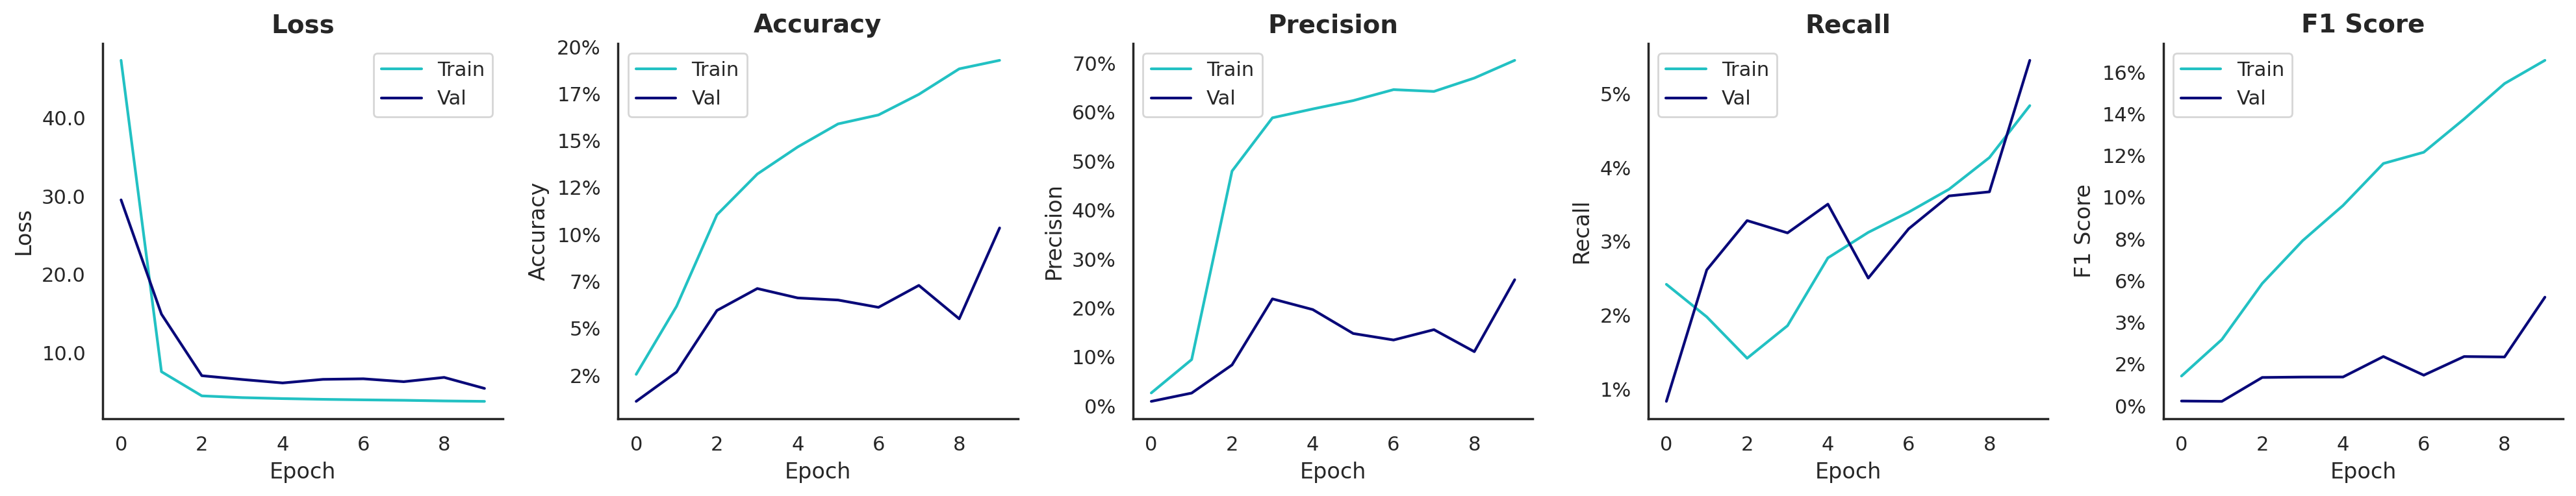

In [38]:
# Function to plot metrics
def plot_metrics(history):
    """Plots training and validation metrics."""
    fig, ax = plt.subplots(1, 5, figsize=(20, 4))
    metrics = [('loss', 'Loss'), ('accuracy', 'Accuracy'), ('precision', 'Precision'),  ('recall', 'Recall'), ('f1_score', 'F1 Score')]
    for i, (metric, title) in enumerate(metrics):
        ax[i].plot(history.history[metric], label='Train', color='#22c1c3')
        ax[i].plot(history.history[f'val_{metric}'], label='Val', color='#090979')
        ax[i].set_title(title, fontsize=14, fontweight='bold')
        ax[i].set_xlabel('Epoch', fontsize=12)
        ax[i].set_ylabel(title, fontsize=12)
        ax[i].legend()
        ax[i].set_yticklabels([f'{int(t*100)}%' if metric != 'loss' else t for t in ax[i].get_yticks()])
        sns.despine(top=True, right=True)
    plt.tight_layout()
    # plt.savefig('./ModelsEvaluation/2_Training_Validation_Metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_metrics(history)

In [ ]:
# Evaluate on test set
val_results = model.evaluate(val_datagen, batch_size=batch_size, return_dict=True, verbose=0)
test_results = model.evaluate(test_datagen, batch_size=batch_size, return_dict=True, verbose=0)

In [19]:
# Collect results in DataFrame
results_df = pd.DataFrame({
    "Models": ["Baseline Model"],
    "Time of Execution": [train_time],
    "Training Accuracy": [history.history['accuracy'][-1]],
    "Training Precision": [history.history['precision'][-1]],
    "Training Recall": [history.history['recall'][-1]],
    "Training F1 Score": [history.history['f1_score'][-1]],
    "Training AUROC": [history.history['auc'][-1]],
    "Validation Accuracy": [val_results['accuracy']],
    "Validation Precision": [val_results['precision']],
    "Validation Recall": [val_results['recall']],
    "Validation F1 Score": [val_results['f1_score']],
    "Validation AUROC": [val_results['auc']],
    "Test Accuracy": [test_results['accuracy']],
    "Test Precision": [test_results['precision']],
    "Test Recall": [test_results['recall']],
    "Test F1 Score": [test_results['f1_score']],
    "Test AUROC": [test_results['auc']]
})

train_df = results_df[['Models', 'Time of Execution', 'Training Accuracy', 
                       'Training Precision', 'Training Recall', 'Training F1 Score', 'Training AUROC']]
# Remove "Training" prefix from column names
train_df.columns = train_df.columns.str.replace('Training ', '', regex=False)
# Set the index to "Models"
train_df.set_index('Models', inplace=True)

val_df = results_df[['Models', 'Validation Accuracy', 'Validation Precision', 'Validation Recall', 
                     'Validation F1 Score', 'Validation AUROC']]
# Remove "Validation" prefix from column names
val_df.columns = val_df.columns.str.replace('Validation ', '', regex=False)
# Set the index to "Models"
val_df.set_index('Models', inplace=True)

test_df = results_df[['Models', 'Test Accuracy', 'Test Precision', 'Test Recall', 
                      'Test F1 Score', 'Test AUROC']]
# Remove "Test" prefix from column names
test_df.columns = test_df.columns.str.replace('Test ', '', regex=False)
# Set the index to "Models"
test_df.set_index('Models', inplace=True)

display_side_by_side(train_df, val_df, test_df, 
                     titles=["Training Set", "Validation Set", "Test Set"], 
                     super_title="Classification Models | Results")

Classification Models | Results Training Set 
 
 
 
 Time of Execution 
 Accuracy 
 Precision 
 Recall 
 F1 Score 
 AUROC 
 
 
 Models 
 
 
 
 
 
 
 
 
 
 
 Baseline Model 
 302.3 
 0.223772 
 0.789379 
 0.104554 
 0.256954 
 0.813739 
 
 
 Validation Set 
 
 
 
 Accuracy 
 Precision 
 Recall 
 F1 Score 
 AUROC 
 
 
 Models 
 
 
 
 
 
 
 
 
 
 Baseline Model 
 0.005565 
 0.005565 
 0.005565 
 0.00056 
 0.500299 
 
 
 Test Set 
 
 
 
 Accuracy 
 Precision 
 Recall 
 F1 Score 
 AUROC 
 
 
 Models 
 
 
 
 
 
 
 
 
 
 Baseline Model 
 0.006118 
 0.006118 
 0.006118 
 0.000841 
 0.500577

In [18]:
# Save to CSV
results_df.set_index('Models', inplace=True)
results_df.to_csv("ModelsEvaluation/BaselineModelEvaluation_1_29.03.2025.csv", index=False)                ### Change the name of the file to save it

---

---

# **🔗 Bibliography/References**

**[[1]](https://)** AAAAAAAAAA

---